In [1]:
import sys

# Add the parent directory to the system path
sys.path.append("../04_survival_models/src")

In [2]:
import os

import numpy as np
import pandas as pd
import mlflow
from tqdm import tqdm
from uc2_functions import *
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
import math
from tabulate import tabulate
import shap

In [3]:
pd.set_option('future.no_silent_downcasting', True)

# Goal

The goal is to provide Global Explanations of the final models.

# Parameters

In [4]:
# Directories
DIR_SC = os.path.join(os.path.dirname(os.getcwd()), "sc")
# Legend
PATH_LEGEND = "Legenda_Variabili_Uri_Larcher.xlsx"
RANDOM_STATE = 42

# Functions

In [5]:
class FeatureAligner:
    def __init__(self, imputer, feature_names):
        self.imputer = imputer
        self.feature_names = feature_names

    def transform(self, X):
        # Create a DataFrame with the feature names and fill missing columns with NaN
        X_aligned = pd.DataFrame(columns=self.feature_names)
        for col in X.columns:
            if col in self.feature_names:
                X_aligned[col] = X[col]
        X_aligned = X_aligned.fillna(np.nan)
        # Transform the aligned DataFrame
        return self.imputer.transform(X_aligned)

# Data ingestion

## [internal]

In [6]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required

subscription_id = "753a0b42-95dc-4871-b53e-160ceb0e6bc1"
resource_group = "rg-s-race-aml-dev-we"
workspace_name = "amlsraceamldevwe01"

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name="UC2_raw_survival_csm_ohe_5yrs")
df_ohe = dataset.to_pandas_dataframe()
print(df_ohe.shape)
df_ohe.head()

{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}
(2536, 211)


,P_1_id,ANM_1_previousAbdominalOperations,ANM_1_moduliOK,ANM_1_performanceStatus,ANM_1_asa,ANM_1_patientBMI,ANM_1_hypertension,ANM_1_TerapiaDiabeteIpoglicemizzanti,ANM_1_charlsonIndexComorbiditiesMalattiaPolmonare,ANM_1_charlsonIndexComorbiditiesUlceraPeptica,...,DEG_1_examEmCreatininemiaRange_14-18,DEG_1_examEmCalcioRange_14-18,"DEG_1_examEmCalcioRange_2,10-2,60",DEG_1_examEmCalcioRange_2_1-2_6,DEG_1_examEmCalcioRange_2_10-2_60,DEG_1_examEmCalcioRange_2_25-2_75,death,csm,ocm,ttdeath
0,1.0,False,False,0.0,1.0,24.82,False,<NA>,True,False,...,False,False,False,False,True,False,False,False,True,60.0
1,4.0,False,False,1.0,2.0,NaN,True,False,False,False,...,False,False,False,False,True,False,False,<NA>,<NA>,60.0
2,5.0,True,False,1.0,2.0,NaN,True,False,False,False,...,False,False,False,False,True,False,False,False,False,60.0
3,6.0,False,False,1.0,2.0,29.76,False,<NA>,False,False,...,False,False,False,False,True,False,False,False,False,60.0
4,7.0,True,False,1.0,2.0,26.57,False,False,False,False,...,False,False,False,False,False,False,False,False,False,60.0


### Use schema from [internal]

Recreate the schema from tags:

In [7]:
tags = dataset.tags

dtypes = json.loads(tags["dtypes_json"])
is_ordinal = json.loads(tags["is_ordinal_json"])

for col in dtypes.keys():
    if dtypes[col] == "category":
        categories = (
            sorted(df_ohe[col].dropna().unique())
            if is_ordinal[col]
            else df_ohe[col].dropna().unique()
        )
        df_ohe[col] = pd.Categorical(
            df_ohe[col], categories=categories, ordered=is_ordinal[col]
        )
    else:
        df_ohe[col] = df_ohe[col].astype(dtypes[col])

# Load imputer trained on [internal]

In [8]:
run_id = '0a238298-0171-47bd-b413-8cd3606ae59f'
artifact_path = 'raw_IterativeImputer_final_42.pkl'


file_path = mlflow.artifacts.download_artifacts(run_id=run_id, # `Overview > Name` in the UI
                                                artifact_path=artifact_path) # `Outputs + tags > .pkl filename` in the UI

# Load model
imputer = joblib.load(
    file_path
)
# List of features
features_imputer = imputer.feature_names_in_
print(len(features_imputer))

206


# [internal] Create imputed version

In [9]:
col_target = ['death', 'csm', 'ocm', 'ttdeath']

# Separate features and target
features_all = df_ohe.drop(columns=col_target)
target = df_ohe[col_target]

# Create the aligner
aligner = FeatureAligner(imputer, features_imputer)

# Transform the external dataset features
features_all_imputed = aligner.transform(features_all)

# Reattach the target columns
df_ohe_imputed = pd.concat([pd.DataFrame(features_all_imputed, columns=features_imputer),
                                          target.reset_index(drop=True)], axis=1)

# GRANT finetune `CoxPHSurvivalAnalysis_grant_finetune_T1_final`

##  [internal] Binarize variables

In [10]:
## Binarize age
df_ohe_imputed['ANM_1_age_binary'] = (df_ohe_imputed['ANM_1_age'] > 60).astype("boolean")
## Binarize pT
df_ohe_imputed['IST_1_kidney1PathologicalStage2009_binary'] = (df_ohe_imputed['IST_1_kidney1PathologicalStage2009'] >= 6).astype("boolean")
## Binarize grading
df_ohe_imputed['IST_1_kidney1Grading_binary'] = (df_ohe_imputed['IST_1_kidney1Grading'] >= 3).astype("boolean")

## Load model trained on [internal]

In [11]:
run_id = 'ea289aa3-8c62-4372-90aa-7212015afe49'
artifact_path = 'raw_CoxPHSurvivalAnalysis_grant_finetune_T1_final_42.pkl'


file_path = mlflow.artifacts.download_artifacts(run_id=run_id, # `Overview > Name` in the UI
                                                artifact_path=artifact_path) # `Outputs + tags > .pkl filename` in the UI

# Load model
cox_grant_finetune = joblib.load(
    file_path
)
# List of features
features_grant_finetune = cox_grant_finetune.feature_names_in_
print(features_grant_finetune)

['ANM_1_age_binary' 'IST_1_kidney1PathologicalStage2009_binary'
 'IST_1_kidney1PN2009_1_0' 'IST_1_kidney1Grading_binary']


## Hyperparameters

In [12]:
print(cox_grant_finetune.get_params())

{'alpha': 0, 'n_iter': 100, 'ties': 'breslow', 'tol': 1e-09, 'verbose': 0}


## Coef

In [13]:
table = pd.DataFrame(
    [features_grant_finetune, cox_grant_finetune.coef_, [math.exp(i) for i in cox_grant_finetune.coef_]]
).T
table.columns = ["Risk Factor", "Coefficient [β]", "Relative Risk [exp(β)]"]

print(
    tabulate(
        table,
        headers=["Risk Factor", "Coefficient [β]", "Relative Risk [exp(β)]"],
        tablefmt="fancy_grid",
        colalign=("center", "center", "center"),
        floatfmt=".3f",
    )
)

╒════╤═══════════════════════════════════════════╤═══════════════════╤══════════════════════════╕
│    │                Risk Factor                │  Coefficient [β]  │   Relative Risk [exp(β)] │
╞════╪═══════════════════════════════════════════╪═══════════════════╪══════════════════════════╡
│ 0  │             ANM_1_age_binary              │       0.393       │                    1.481 │
├────┼───────────────────────────────────────────┼───────────────────┼──────────────────────────┤
│ 1  │ IST_1_kidney1PathologicalStage2009_binary │       1.280       │                    3.597 │
├────┼───────────────────────────────────────────┼───────────────────┼──────────────────────────┤
│ 2  │          IST_1_kidney1PN2009_1_0          │       1.710       │                    5.527 │
├────┼───────────────────────────────────────────┼───────────────────┼──────────────────────────┤
│ 3  │        IST_1_kidney1Grading_binary        │       1.609       │                    5.000 │
╘════╧══════════════

# GRANT plus `CoxPHSurvivalAnalysis_grant_plus_T1_final`

## Load model trained on [internal]

In [14]:
run_id = 'f57d561d-a83b-4895-8f06-75c5c4df1d53'
artifact_path = 'raw_CoxPHSurvivalAnalysis_grant_plus_T1_final_42.pkl'


file_path = mlflow.artifacts.download_artifacts(run_id=run_id, # `Overview > Name` in the UI
                                                artifact_path=artifact_path) # `Outputs + tags > .pkl filename` in the UI

# Load model
cox_grant_plus = joblib.load(
    file_path
)
# List of features
features_grant_plus = cox_grant_plus.feature_names_in_
print(features_grant_plus)

['ANM_1_age' 'IST_1_kidney1PathologicalStage2009'
 'IST_1_kidney1PN2009_1_0' 'IST_1_kidney1Grading']


## Hyperparameters

In [15]:
print(cox_grant_plus.get_params())

{'alpha': 0, 'n_iter': 100, 'ties': 'breslow', 'tol': 1e-09, 'verbose': 0}


## Coef

In [16]:
table = pd.DataFrame(
    [features_grant_plus, cox_grant_plus.coef_, [math.exp(i) for i in cox_grant_plus.coef_]]
).T
table.columns = ["Risk Factor", "Coefficient [β]", "Relative Risk [exp(β)]"]

print(
    tabulate(
        table,
        headers=["Risk Factor", "Coefficient [β]", "Relative Risk [exp(β)]"],
        tablefmt="fancy_grid",
        colalign=("center", "center", "center"),
        floatfmt=".3f",
    )
)

╒════╤════════════════════════════════════╤═══════════════════╤══════════════════════════╕
│    │            Risk Factor             │  Coefficient [β]  │   Relative Risk [exp(β)] │
╞════╪════════════════════════════════════╪═══════════════════╪══════════════════════════╡
│ 0  │             ANM_1_age              │       0.011       │                    1.012 │
├────┼────────────────────────────────────┼───────────────────┼──────────────────────────┤
│ 1  │ IST_1_kidney1PathologicalStage2009 │       0.438       │                    1.549 │
├────┼────────────────────────────────────┼───────────────────┼──────────────────────────┤
│ 2  │      IST_1_kidney1PN2009_1_0       │       1.466       │                    4.330 │
├────┼────────────────────────────────────┼───────────────────┼──────────────────────────┤
│ 3  │        IST_1_kidney1Grading        │       0.867       │                    2.380 │
╘════╧════════════════════════════════════╧═══════════════════╧══════════════════════════╛

# T1 model `ComponentwiseGradientBoostingSurvivalAnalysis_T1_DBURI`

## Load model trained on [internal]

In [17]:
run_id = 'c75be180-fe08-49e3-b556-a446a870cb13'
artifact_path = 'raw_ComponentwiseGradientBoostingSurvivalAnalysis_T1_DBURI_42.pkl'


file_path = mlflow.artifacts.download_artifacts(run_id=run_id, # `Overview > Name` in the UI
                                                artifact_path=artifact_path) # `Outputs + tags > .pkl filename` in the UI

# Load model
cwg_t1_dburi = joblib.load(
    file_path
)
# List of features
features_cwg_t1_dburi = cwg_t1_dburi.feature_names_in_
print(features_cwg_t1_dburi)

['ANM_1_examEmPiastrine' 'DEG_1_hospitalStayDaysPostOp'
 'IST_1_kidney1TumorDimension' 'ANM_1_examEmEmoglobina' 'DEG_1_examEmGFR'
 'ANM_1_examEmeGFR' 'ANM_1_age' 'ANM_1_asa' 'IST_1_kidney1Grading'
 'IST_1_kidney1PN2009_1_0']


## Hyperparameters

In [18]:
print(cwg_t1_dburi.get_params())

{'dropout_rate': 0, 'learning_rate': 0.1, 'loss': 'coxph', 'n_estimators': 500, 'random_state': 42, 'subsample': 0.75, 'verbose': 0}


## XAI

In [19]:
X = df_ohe_imputed[features_cwg_t1_dburi]
y = np.array(
    [(event, time) for event, time in zip(df_ohe_imputed["death"], df_ohe_imputed["ttdeath"])],
    dtype=[("event", bool), ("time", int)],
)

### Permutation importance

In [20]:
result = permutation_importance(
    cwg_t1_dburi,
    X,
    y,
    n_repeats=1000,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

# Crate dataframe
df_importance_t1_dburi = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X.columns,
).sort_values(by="importances_mean", ascending=False)
del result

# Get definition from dictionary
df_importance_t1_dburi["feature_definition"] = df_importance_t1_dburi.index

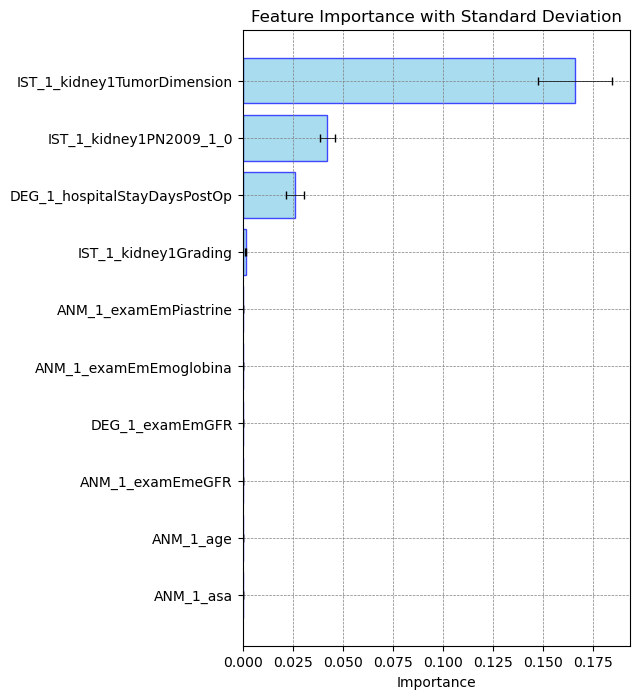

In [21]:
plot_feature_importance(df_importance_t1_dburi, len(features_cwg_t1_dburi), (5, 8))

## SHAP (SHapley Additive exPlanations)

In [22]:
explainer_t1 = shap.Explainer(cwg_t1_dburi.predict,
                           X,
                           seed=RANDOM_STATE,
                          )
shaps_t1 = explainer_t1(X)

ExactExplainer explainer: 2537it [05:31,  7.66it/s]                          


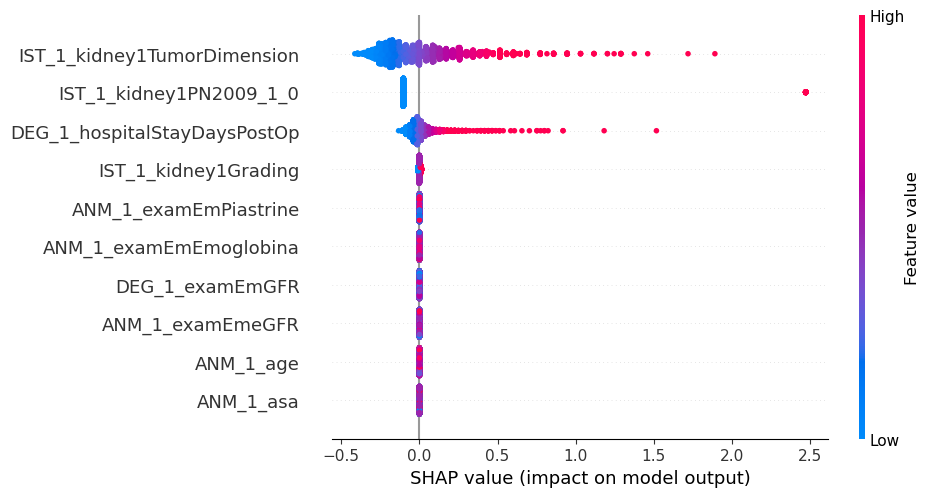

In [23]:
shap.plots.beeswarm(shaps_t1, max_display=len(features_cwg_t1_dburi))

In [24]:
del shaps_t1

# T0 model `ExtraSurvivalTrees_T0_DBURI`

In [25]:
run_id = '4df6fac1-2f1e-4717-bcbc-e81a6883bec3'
artifact_path = 'raw_ExtraSurvivalTrees_T0_DBURI_42.pkl'


file_path = mlflow.artifacts.download_artifacts(run_id=run_id, # `Overview > Name` in the UI
                                                artifact_path=artifact_path) # `Outputs + tags > .pkl filename` in the UI

# Load model
est_t0_dburi = joblib.load(
    file_path
)
# List of features
features_est_t0_dburi = est_t0_dburi.feature_names_in_
print(features_est_t0_dburi)

['ANM_1_examEmPiastrine' 'ANM_1_kidney1NeoplasiaDimension1'
 'ANM_1_examEmEmoglobina' 'ANM_1_age' 'ANM_1_performanceStatus'
 'ANM_1_examEmeGFR' 'ANM_1_lymphadenopathy_Positivo' 'ANM_1_patientBMI']


## Hyperparameters

In [26]:
print(est_t0_dburi.get_params())

{'bootstrap': True, 'low_memory': False, 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 5, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


## XAI

In [27]:
X = df_ohe_imputed[features_est_t0_dburi]
y = np.array(
    [(event, time) for event, time in zip(df_ohe_imputed["death"], df_ohe_imputed["ttdeath"])],
    dtype=[("event", bool), ("time", int)],
)

### Permutation importance

In [28]:
result = permutation_importance(
    est_t0_dburi,
    X,
    y,
    n_repeats=1000,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

# Crate dataframe
df_importance_t0 = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X.columns,
).sort_values(by="importances_mean", ascending=False)
del result

# Get definition from dictionary
df_importance_t0["feature_definition"] = df_importance_t0.index

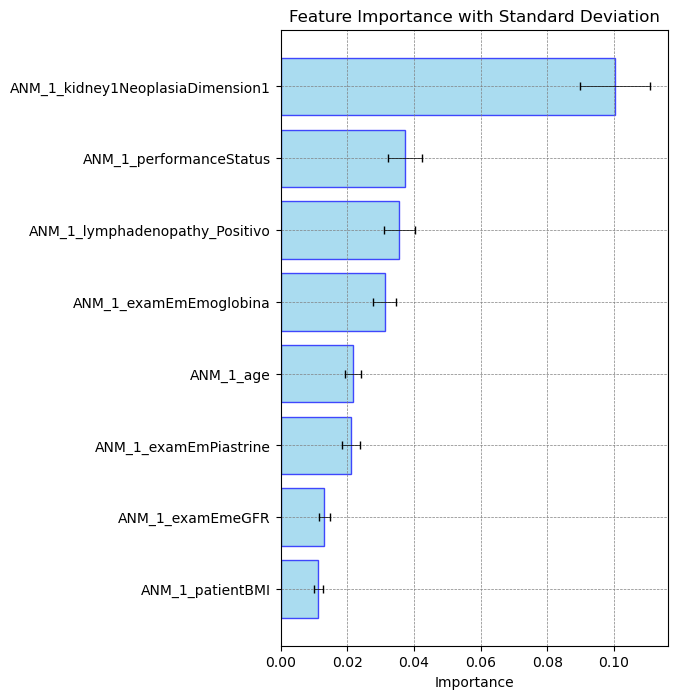

In [29]:
plot_feature_importance(df_importance_t0, len(features_est_t0_dburi), (5, 8))

## SHAP (SHapley Additive exPlanations)

In [30]:
explainer_t0 = shap.Explainer(est_t0_dburi.predict,
                           X,
                           seed=RANDOM_STATE,
                          )
shaps_t0 = explainer_t0(X)

ExactExplainer explainer: 2537it [33:40,  1.25it/s]                          


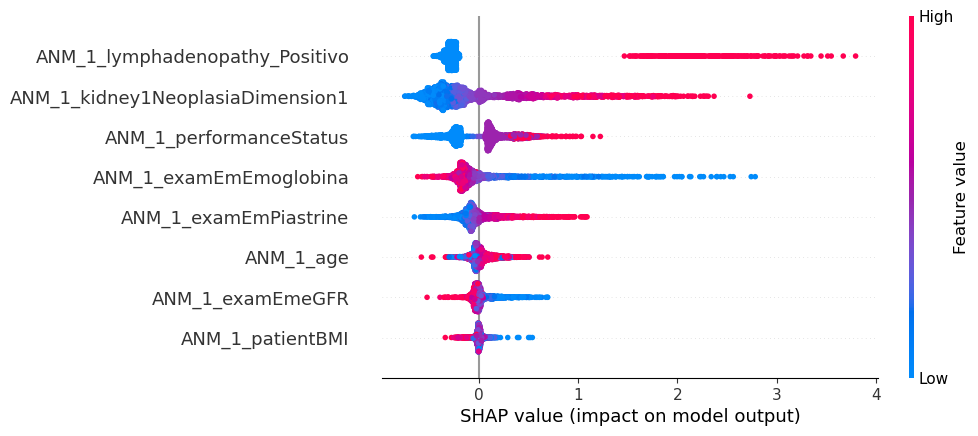

In [31]:
shap.plots.beeswarm(shaps_t0, max_display=len(features_est_t0_dburi))

In [32]:
del shaps_t0